# 作业第5周   循环神经网络练习

1.仿照课件关于IMDb数据集的分类训练，在课件示例基础上改用GRU、优化网络层数与其它参数，尽力提升分类准确率。<BR>
要求：使用callback方法保存最佳模型；训练完成后将保存在文件的模型读入，用于评估与预测测试集样本。<BR>
请每个人在"save"目录下建立以自己学号命名的子目录，然后在该子目录下保存文件

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(1,1024)

Thu Jun  1 14:35:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 48%   49C    P2   123W / 350W |  24257MiB / 24268MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 69%   

# 数据准备
IMDB 数据集包含来自互联网电影数据库（IMDB）的 50 000 条严重两极分化的评论。  
数据集被分为用于训练的 25 000 条评论与用于测试的 25 000 条评论，训练集和测试集都包含 50% 的正面评论和 50% 的负面评论。  
train_labels 和 test_labels 都是 0 和 1 组成的列表，其中 0代表负面（negative），1 代表正面（positive）

In [2]:
import tensorflow as tf

max_feature = 25000
maxlen = 512
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words = max_feature)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(25000,) (25000,) (25000,) (25000,)


In [3]:
word_index = tf.keras.datasets.imdb.get_word_index()
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [4]:
index_to_word = {v:k for k,v in word_index.items()}
index_to_word

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [5]:
#查看影评
' '.join([index_to_word[x] for x in x_train[0]])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when fro

# 文章文字等长处理
每一篇的文章所产生的数字列表长度都不同，因为之后需要进行类神经网络的训练，所以每一篇文章所产生的数字长度必须相同.   
以下列程序代码为例maxlen=380，所以每一篇文章转换为数字都必须为380    
如果文章转成数字大于0,pad_sequences处理后，会truncate前面的数字    
如果文章转成数字不足100,pad_sequences处理后，前面会加上0  

In [6]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
#文字等长处理
x_train_pad = sequence.pad_sequences(x_train, maxlen = maxlen)
x_val_pad = sequence.pad_sequences(x_val, maxlen = maxlen)

# 建立模型

In [7]:
#建立模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN,LSTM,GRU
from tensorflow.keras.optimizers import SGD,Adam

model  = Sequential()

model.add(Embedding(output_dim = 256, input_dim = max_feature, input_length = maxlen))
model.add(GRU(units= 256, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1,activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 256)          6400000   
                                                                 
 gru (GRU)                   (None, 256)               394752    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 6,795,009
Trainable params: 6,795,009
Non-trainable params: 0
_________________________________________________________________


# keras-Embedding层
代替One-Hot编码嵌入层（Embedding Layer）是使用在模型第一层的一个网络层，其目的是将所有索引标号映射到致密的低维向量中，  
比如文本集[[4],[32],[67]]被映射为[[0.3,0.9,0.2],[-0.2,0.1,0,8],[0.1,0.3,0.9]]。  
该层通常用于文本数据建模。  
输入数据要求是一个二维张量：(1个批次内的文本数,每篇文本中的词语数)，输出为一个三维张量：(1个批次内的文本数, 每篇文本中的词语数,每个词语的维度)。

In [8]:
#回调模型
from tensorflow.keras.callbacks import ModelCheckpoint
save_path = 'save/3200100259/week5_bestmodel.h5'
cp_callback = ModelCheckpoint(filepath = save_path, monitor = 'val_accuracy', save_best_only = True)

# 训练模型

In [9]:
#训练模型
opt = Adam(learning_rate = 1e-4, decay = 1e-3)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
train_history = model.fit(x_train_pad,y_train,batch_size = 64, epochs = 6,verbose = 1,validation_split = 0.2,
                          callbacks = [cp_callback])

Epoch 1/6
313/313 [==============================] - 22s 53ms/step - loss: 0.6553 - accuracy: 0.6246 - val_loss: 0.5173 - val_accuracy: 0.7536
Epoch 2/6
313/313 [==============================] - 15s 47ms/step - loss: 0.3851 - accuracy: 0.8363 - val_loss: 0.3359 - val_accuracy: 0.8536
Epoch 3/6
313/313 [==============================] - 15s 47ms/step - loss: 0.2277 - accuracy: 0.9133 - val_loss: 0.2800 - val_accuracy: 0.8818
Epoch 4/6
313/313 [==============================] - 15s 49ms/step - loss: 0.1700 - accuracy: 0.9392 - val_loss: 0.2733 - val_accuracy: 0.8876
Epoch 5/6
313/313 [==============================] - 17s 56ms/step - loss: 0.1312 - accuracy: 0.9560 - val_loss: 0.2747 - val_accuracy: 0.8872
Epoch 6/6
313/313 [==============================] - 18s 57ms/step - loss: 0.1053 - accuracy: 0.9677 - val_loss: 0.2824 - val_accuracy: 0.8970


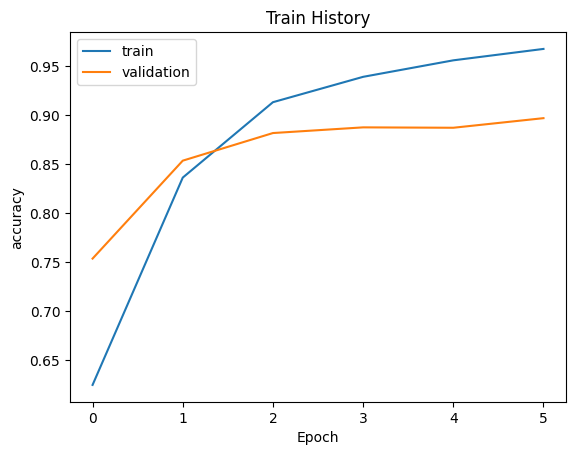

In [10]:
import matplotlib.pyplot as plt
def show_train_his(train_history,train,val):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()
    
show_train_his(train_history,'accuracy','val_accuracy')

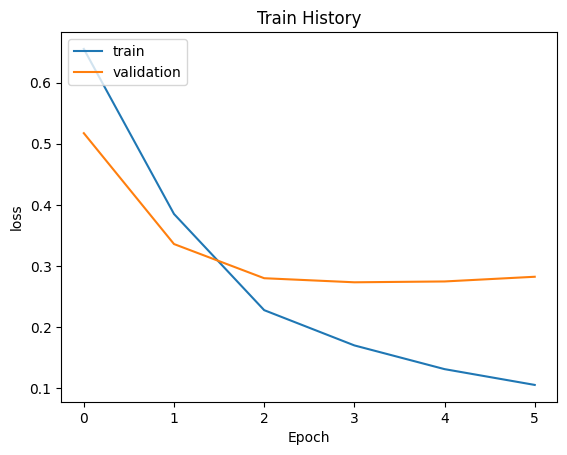

In [11]:
show_train_his(train_history,'loss','val_loss')

# 评估模型的准确率

In [12]:
#读取保存的模型
model.load_weights(save_path)
scores = model.evaluate(x_val_pad,y_val,verbose = 1)
scores[1]

782/782 [==============================] - 15s 20ms/step - loss: 0.3079 - accuracy: 0.8808


0.880840003490448